In [1]:
import models
import utils
import data_processing
from constants import (
    VALUE_COLUMN,
    UNIT_RATE_COLUMN,
    QUANTITY_COLUMN,
    GROSS_WEIGHT_COLUMN,
    SHIP_COUNT_COLUMN,
    PORT_COUNT_COLUMN,
    FILL_METHOD,
    TARGET_COLUMN,
    VOLZA_COLUMNS,
    AIS_COLUMNS,
    OIL_COLUMNS,
    ARIMA_RESIDUAL_COLUMN,
    RANDOM_STATE
)
import pandas as pd
import constants
import sys
from datetime import datetime
from build_data import get_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

import matplotlib.pyplot as plt
import numpy as np

In [2]:
COMMODITYS = ['cobalt', 'copper', 'germanium', 'magnesium']
target_COMMODITY = "copper"
WINDOW_SIZE = 20

In [3]:
pre_features = []
pre_labels = []
tar_features = []
tar_labels = []
# for COMMODITY in COMMODITYS:
COMMODITY = target_COMMODITY

VOLZA_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}.csv"
PRICE_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}_prices.csv"

# Get the data
data = get_data(VOLZA_FILE_PATH, PRICE_FILE_PATH, window_size=WINDOW_SIZE, center=False)

# Add Isolation Forest spikes column
data['spikes_if'] = utils.detect_spikes_if(data, TARGET_COLUMN + VOLZA_COLUMNS, contamination=0.05)

# Add Bowen's spike detection
spikes, features, labels = utils.detect_spikes_new(data, TARGET_COLUMN, window_size=WINDOW_SIZE, center=False)
if COMMODITY == target_COMMODITY:
    tar_features.extend(features)
    tar_labels.extend(labels)
    #     continue
    # pre_features.extend(features)
    # pre_labels.extend(labels)

data.head(2)

Building data...


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={"Value": "Brent Oil Value"}, inplace=True)
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={"Value": "WTI Oil Value"}, inplace=True)
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\analysis\build_data.py:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() inste

Rows dropped due to NaN values: 1
Detecting spikes... 20


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),Price,Brent Oil Value,WTI Oil Value,ARIMA_Residuals,spikes,spikes_if
1,2019-01-02,28997742.33,4504496.0,4507752.0,6.420416,2.6250,54.06,46.31,2.6250,0,0
2,2019-01-03,16525428.57,2427492.0,2428782.0,9.079466,2.5705,53.23,46.92,-0.0545,0,0


Spike Percentage: 16.65%


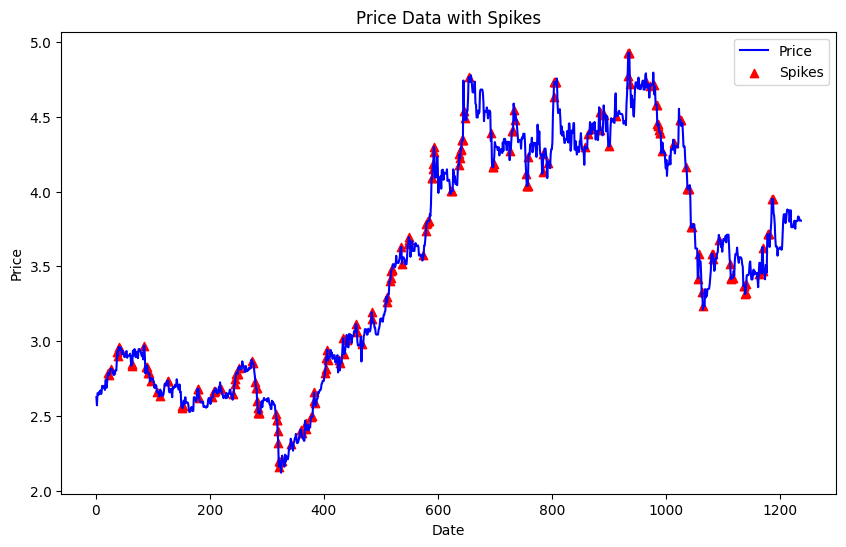

In [4]:
padded_spikes = np.pad(spikes, (data.shape[0] - len(spikes), 0), 'constant', constant_values=(0,))
data['spikes_new'] = padded_spikes
utils.plot_prices(data,column='spikes_new')

In [5]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

sampler = RandomOverSampler
output_file_path = f'{target_COMMODITY}/test/results_test.csv'
pred_file_path = f'{target_COMMODITY}/test/predictions/test'
model_path = f'{target_COMMODITY}/best_model'

In [6]:
aggregated_df = data
SPIKE_COLUMN = 'spikes_if'

In [7]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

aggregated_df['Price_binned'] = discretizer.fit_transform(aggregated_df[['Price']])
aggregated_df

c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),Price,Brent Oil Value,WTI Oil Value,ARIMA_Residuals,spikes,spikes_if,spikes_new,Price_binned
1,2019-01-02,2.899774e+07,4.504496e+06,4507752.0,6.420416,2.6250,54.06,46.31,2.625000e+00,0,0,0,0.0
2,2019-01-03,1.652543e+07,2.427492e+06,2428782.0,9.079466,2.5705,53.23,46.92,-5.450000e-02,0,0,0,0.0
3,2019-01-04,1.381037e+05,1.978600e+04,0.0,5.651829,2.6515,55.64,47.76,8.100000e-02,0,0,0,0.0
4,2019-01-06,1.854971e+07,3.025544e+06,0.0,3947.152515,2.6515,55.64,47.76,2.039406e-09,0,0,0,0.0
5,2019-01-07,3.339545e+07,5.543534e+06,4648720.0,3074.211012,2.6410,57.10,48.27,-1.050000e-02,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,2022-12-28,3.660210e+07,4.590079e+06,2301364.0,7.600228,3.8320,81.70,78.89,-5.630000e-01,0,0,0,3.0
1234,2022-12-29,9.597299e+06,2.434564e+06,2415.6,13.516123,3.8210,80.96,78.43,-5.740000e-01,0,0,0,3.0
1235,2022-12-30,1.148950e+08,2.272949e+06,360.0,371.032957,3.8055,82.82,80.16,-5.895000e-01,0,0,0,3.0
1236,2022-12-31,1.290664e+07,1.515365e+06,0.0,8.285327,3.8055,82.82,80.16,-5.895000e-01,0,0,0,3.0


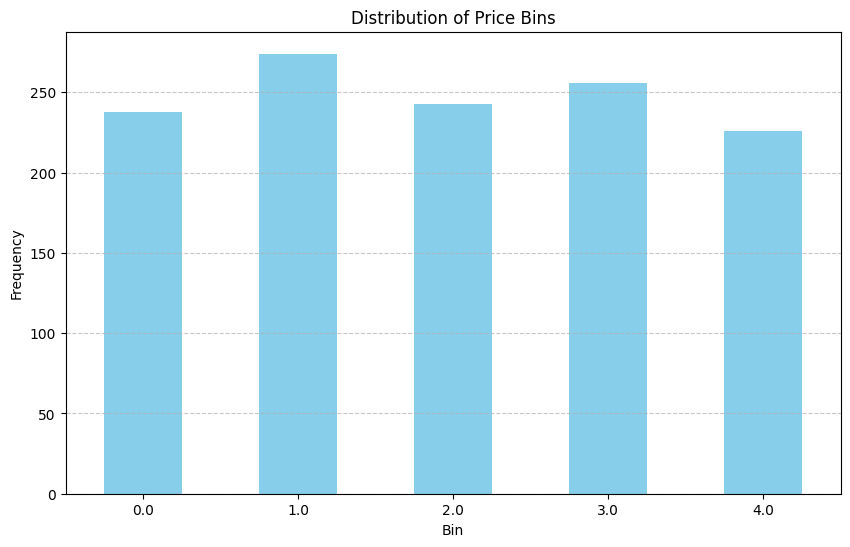

In [8]:
import matplotlib.pyplot as plt

# Assuming 'Price_binned' has been properly added to 'aggregated_df'
# Count the frequency of each bin
bin_counts = aggregated_df['Price_binned'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Price Bins')
plt.xlabel('Bin')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [9]:
# TARGET_COLUMN = ['Price_binned']

In [10]:
# Prepare price data
# X_price, y_price = data_processing.prepare_features_and_target(aggregated_df, TARGET_COLUMN, 'spikes')
X_price = np.array(tar_features)
y_price = np.array(tar_labels)

# Split price data
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_price, y_price, test_size=0.3, random_state=RANDOM_STATE, shuffle=False)
X_train_price, X_val_price, y_train_price, y_val_price = train_test_split(X_train_price, y_train_price, test_size=(10/70), random_state=RANDOM_STATE, shuffle=False)

# Discretizing


# Balancing
X_train_price, y_train_price = sampler(random_state=RANDOM_STATE).fit_resample(X_train_price, y_train_price)

# Scaling
X_train_price, X_test_price, X_val_price = data_processing.scale_features(X_train_price, X_test_price, X_val_price)

# Sequence making
# X_train_price, y_train_price = data_processing.create_sequences(X_train_price, y_train_price, WINDOW_SIZE)
# X_test_price, y_test_price = data_processing.create_sequences(X_test_price, y_test_price, WINDOW_SIZE)
# X_val_price, y_val_price = data_processing.create_sequences(X_val_price, y_val_price, WINDOW_SIZE)


X_train_price = np.expand_dims(X_train_price, axis = 2)
X_test_price = np.expand_dims(X_test_price, axis = 2)
X_val_price = np.expand_dims(X_val_price, axis = 2)

In [11]:
results_df  = models.evaluate_all(X_train_price, y_train_price, X_val_price, y_val_price, X_test_price, y_test_price, output_file_path, pred_file_path, model_path, False, False)


12/12 [==============================] - 0s 4ms/step
Predictions saved to CSV file: copper/test/predictions/test/LSTM_256_layers_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/LSTM_256_layers_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/LSTM_256_layers_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/LSTM_256_layers_predictions.npy
{'Name': 'LSTM', 'Params': '256 layers', 'Accuracy': 0.4821917808219178, 'Precision (0)': 0.8241758241758241, 'Recall (0)': 0.48859934853420195, 'F1 (0)': 0.6134969325153374, 'Precision (1)': 0.14207650273224043, 'Recall (1)': 0.4482758620689655, 'F1 (1)': 0.21576763485477182, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 3ms/step
Predictions saved to CSV file: copper/test/predictions/test/LSTM_128_layers_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/LSTM_128_layers_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/LSTM_128_layers_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/LSTM_128_layers_predictions.npy
{'Name': 'LSTM', 'Params': '128 layers', 'Accuracy': 0.4849315068493151, 'Precision (0)': 0.825136612021858, 'Recall (0)': 0.49185667752442996, 'F1 (0)': 0.6163265306122448, 'Precision (1)': 0.14285714285714285, 'Recall (1)': 0.4482758620689655, 'F1 (1)': 0.21666666666666665, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 2ms/step
Predictions saved to CSV file: copper/test/predictions/test/LSTM_64_layers_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/LSTM_64_layers_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/LSTM_64_layers_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/LSTM_64_layers_predictions.npy
{'Name': 'LSTM', 'Params': '64 layers', 'Accuracy': 0.4136986301369863, 'Precision (0)': 0.8251748251748252, 'Recall (0)': 0.38436482084690554, 'F1 (0)': 0.5244444444444445, 'Precision (1)': 0.14864864864864866, 'Recall (1)': 0.5689655172413793, 'F1 (1)': 0.2357142857142857, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/LSTM_32_layers_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/LSTM_32_layers_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/LSTM_32_layers_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/LSTM_32_layers_predictions.npy
{'Name': 'LSTM', 'Params': '32 layers', 'Accuracy': 0.8410958904109589, 'Precision (0)': 0.8410958904109589, 'Recall (0)': 1.0, 'F1 (0)': 0.9136904761904762, 'Precision (1)': 0.0, 'Recall (1)': 0.0, 'F1 (1)': 0.0, 'Prior': '0.16'}



c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_32_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_32_filters_7_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_Attention_32_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_Attention_32_filters_7_kernels_predictions.npy
CNN_Attention_32_filters_7_kernels {'Name': 'CNN with Attention', 'Params': '32 filters, kernel size 7', 'Accuracy': 0.5287671232876713, 'Precision (0)': 0.8325123152709359, 'Recall (0)': 0.5504885993485342, 'F1 (0)': 0.6627450980392157, 'Precision (1)': 0.14814814814814814, 'Recall (1)': 0.41379310344827586, 'F1 (1)': 0.2181818181818182, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_32_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_32_filters_5_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_Attention_32_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_Attention_32_filters_5_kernels_predictions.npy
CNN_Attention_32_filters_5_kernels {'Name': 'CNN with Attention', 'Params': '32 filters, kernel size 5', 'Accuracy': 0.5780821917808219, 'Precision (0)': 0.8370044052863436, 'Recall (0)': 0.6188925081433225, 'F1 (0)': 0.7116104868913857, 'Precision (1)': 0.15217391304347827, 'Recall (1)': 0.3620689655172414, 'F1 (1)': 0.21428571428571433, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_32_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_32_filters_3_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_Attention_32_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_Attention_32_filters_3_kernels_predictions.npy
CNN_Attention_32_filters_3_kernels {'Name': 'CNN with Attention', 'Params': '32 filters, kernel size 3', 'Accuracy': 0.6164383561643836, 'Precision (0)': 0.8408163265306122, 'Recall (0)': 0.6710097719869706, 'F1 (0)': 0.7463768115942028, 'Precision (1)': 0.15833333333333333, 'Recall (1)': 0.3275862068965517, 'F1 (1)': 0.21348314606741572, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_64_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_64_filters_7_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_Attention_64_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_Attention_64_filters_7_kernels_predictions.npy
CNN_Attention_64_filters_7_kernels {'Name': 'CNN with Attention', 'Params': '64 filters, kernel size 7', 'Accuracy': 0.6356164383561644, 'Precision (0)': 0.8346153846153846, 'Recall (0)': 0.7068403908794788, 'F1 (0)': 0.7654320987654321, 'Precision (1)': 0.14285714285714285, 'Recall (1)': 0.25862068965517243, 'F1 (1)': 0.18404907975460125, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_64_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_64_filters_5_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_Attention_64_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_Attention_64_filters_5_kernels_predictions.npy
CNN_Attention_64_filters_5_kernels {'Name': 'CNN with Attention', 'Params': '64 filters, kernel size 5', 'Accuracy': 0.6082191780821918, 'Precision (0)': 0.8416666666666667, 'Recall (0)': 0.6579804560260586, 'F1 (0)': 0.7385740402193783, 'Precision (1)': 0.16, 'Recall (1)': 0.3448275862068966, 'F1 (1)': 0.2185792349726776, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_64_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_64_filters_3_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_Attention_64_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_Attention_64_filters_3_kernels_predictions.npy
CNN_Attention_64_filters_3_kernels {'Name': 'CNN with Attention', 'Params': '64 filters, kernel size 3', 'Accuracy': 0.6164383561643836, 'Precision (0)': 0.8353413654618473, 'Recall (0)': 0.6775244299674267, 'F1 (0)': 0.7482014388489208, 'Precision (1)': 0.14655172413793102, 'Recall (1)': 0.29310344827586204, 'F1 (1)': 0.1954022988505747, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_128_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_128_filters_7_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_Attention_128_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_Attention_128_filters_7_kernels_predictions.npy
CNN_Attention_128_filters_7_kernels {'Name': 'CNN with Attention', 'Params': '128 filters, kernel size 7', 'Accuracy': 0.5698630136986301, 'Precision (0)': 0.8289473684210527, 'Recall (0)': 0.6156351791530945, 'F1 (0)': 0.7065420560747664, 'Precision (1)': 0.1386861313868613, 'Recall (1)': 0.3275862068965517, 'F1 (1)': 0.19487179487179487, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_128_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_128_filters_5_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_Attention_128_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_Attention_128_filters_5_kernels_predictions.npy
CNN_Attention_128_filters_5_kernels {'Name': 'CNN with Attention', 'Params': '128 filters, kernel size 5', 'Accuracy': 0.5671232876712329, 'Precision (0)': 0.8401826484018264, 'Recall (0)': 0.5993485342019544, 'F1 (0)': 0.6996197718631179, 'Precision (1)': 0.15753424657534246, 'Recall (1)': 0.39655172413793105, 'F1 (1)': 0.22549019607843138, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 2ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_128_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_128_filters_3_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_Attention_128_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_Attention_128_filters_3_kernels_predictions.npy
CNN_Attention_128_filters_3_kernels {'Name': 'CNN with Attention', 'Params': '128 filters, kernel size 3', 'Accuracy': 0.589041095890411, 'Precision (0)': 0.8204081632653061, 'Recall (0)': 0.6547231270358306, 'F1 (0)': 0.7282608695652174, 'Precision (1)': 0.11666666666666667, 'Recall (1)': 0.2413793103448276, 'F1 (1)': 0.15730337078651688, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 2ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_256_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_256_filters_7_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_Attention_256_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_Attention_256_filters_7_kernels_predictions.npy
CNN_Attention_256_filters_7_kernels {'Name': 'CNN with Attention', 'Params': '256 filters, kernel size 7', 'Accuracy': 0.5780821917808219, 'Precision (0)': 0.8311688311688312, 'Recall (0)': 0.6254071661237784, 'F1 (0)': 0.7137546468401486, 'Precision (1)': 0.1417910447761194, 'Recall (1)': 0.3275862068965517, 'F1 (1)': 0.19791666666666669, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_256_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_256_filters_5_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_Attention_256_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_Attention_256_filters_5_kernels_predictions.npy
CNN_Attention_256_filters_5_kernels {'Name': 'CNN with Attention', 'Params': '256 filters, kernel size 5', 'Accuracy': 0.663013698630137, 'Precision (0)': 0.8357664233576643, 'Recall (0)': 0.745928338762215, 'F1 (0)': 0.7882960413080895, 'Precision (1)': 0.14285714285714285, 'Recall (1)': 0.22413793103448276, 'F1 (1)': 0.17449664429530198, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_Attention_256_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_Attention_256_filters_3_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_Attention_256_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_Attention_256_filters_3_kernels_predictions.npy
CNN_Attention_256_filters_3_kernels {'Name': 'CNN with Attention', 'Params': '256 filters, kernel size 3', 'Accuracy': 0.5863013698630137, 'Precision (0)': 0.8451327433628318, 'Recall (0)': 0.6221498371335505, 'F1 (0)': 0.7166979362101313, 'Precision (1)': 0.16546762589928057, 'Recall (1)': 0.39655172413793105, 'F1 (1)': 0.23350253807106602, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 2ms/step
Predictions saved to CSV file: copper/test/predictions/test/RNN_256_units_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/RNN_256_units_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/RNN_256_units_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/RNN_256_units_predictions.npy
RNN_256_units: {'Name': 'RNN', 'Params': '256 units', 'Accuracy': 0.6082191780821918, 'Precision (0)': 0.8333333333333334, 'Recall (0)': 0.6677524429967426, 'F1 (0)': 0.7414104882459314, 'Precision (1)': 0.14285714285714285, 'Recall (1)': 0.29310344827586204, 'F1 (1)': 0.192090395480226, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/RNN_128_units_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/RNN_128_units_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/RNN_128_units_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/RNN_128_units_predictions.npy
RNN_128_units: {'Name': 'RNN', 'Params': '128 units', 'Accuracy': 0.5534246575342465, 'Precision (0)': 0.8272727272727273, 'Recall (0)': 0.5928338762214984, 'F1 (0)': 0.6907020872865275, 'Precision (1)': 0.13793103448275862, 'Recall (1)': 0.3448275862068966, 'F1 (1)': 0.19704433497536947, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/RNN_64_units_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/RNN_64_units_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/RNN_64_units_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/RNN_64_units_predictions.npy
RNN_64_units: {'Name': 'RNN', 'Params': '64 units', 'Accuracy': 0.7479452054794521, 'Precision (0)': 0.8524590163934426, 'Recall (0)': 0.8469055374592834, 'F1 (0)': 0.8496732026143791, 'Precision (1)': 0.21666666666666667, 'Recall (1)': 0.22413793103448276, 'F1 (1)': 0.22033898305084748, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/RNN_32_units_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/RNN_32_units_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/RNN_32_units_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/RNN_32_units_predictions.npy
RNN_32_units: {'Name': 'RNN', 'Params': '32 units', 'Accuracy': 0.25753424657534246, 'Precision (0)': 0.6956521739130435, 'Recall (0)': 0.20846905537459284, 'F1 (0)': 0.3208020050125313, 'Precision (1)': 0.10989010989010989, 'Recall (1)': 0.5172413793103449, 'F1 (1)': 0.1812688821752266, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 941us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_32_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_32_filters_7_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_32_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_32_filters_7_kernels_predictions.npy
CNN_32_filters_7_kernels {'Name': 'CNN', 'Params': '32 filters, kernel size 7', 'Accuracy': 0.5753424657534246, 'Precision (0)': 0.8392857142857143, 'Recall (0)': 0.6123778501628665, 'F1 (0)': 0.7080979284369116, 'Precision (1)': 0.15602836879432624, 'Recall (1)': 0.3793103448275862, 'F1 (1)': 0.22110552763819094, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 942us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_32_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_32_filters_5_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_32_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_32_filters_5_kernels_predictions.npy
CNN_32_filters_5_kernels {'Name': 'CNN', 'Params': '32 filters, kernel size 5', 'Accuracy': 0.5123287671232877, 'Precision (0)': 0.8241206030150754, 'Recall (0)': 0.5342019543973942, 'F1 (0)': 0.6482213438735178, 'Precision (1)': 0.13855421686746988, 'Recall (1)': 0.39655172413793105, 'F1 (1)': 0.20535714285714288, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 874us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_32_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_32_filters_3_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_32_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_32_filters_3_kernels_predictions.npy
CNN_32_filters_3_kernels {'Name': 'CNN', 'Params': '32 filters, kernel size 3', 'Accuracy': 0.5589041095890411, 'Precision (0)': 0.8318181818181818, 'Recall (0)': 0.5960912052117264, 'F1 (0)': 0.6944971537001897, 'Precision (1)': 0.14482758620689656, 'Recall (1)': 0.3620689655172414, 'F1 (1)': 0.20689655172413793, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_64_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_64_filters_7_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_64_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_64_filters_7_kernels_predictions.npy
CNN_64_filters_7_kernels {'Name': 'CNN', 'Params': '64 filters, kernel size 7', 'Accuracy': 0.5123287671232877, 'Precision (0)': 0.8341968911917098, 'Recall (0)': 0.5244299674267101, 'F1 (0)': 0.6439999999999999, 'Precision (1)': 0.1511627906976744, 'Recall (1)': 0.4482758620689655, 'F1 (1)': 0.22608695652173907, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 697us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_64_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_64_filters_5_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_64_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_64_filters_5_kernels_predictions.npy
CNN_64_filters_5_kernels {'Name': 'CNN', 'Params': '64 filters, kernel size 5', 'Accuracy': 0.5643835616438356, 'Precision (0)': 0.8363636363636363, 'Recall (0)': 0.5993485342019544, 'F1 (0)': 0.6982922201138521, 'Precision (1)': 0.15172413793103448, 'Recall (1)': 0.3793103448275862, 'F1 (1)': 0.21674876847290642, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 554us/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_64_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_64_filters_3_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_64_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_64_filters_3_kernels_predictions.npy
CNN_64_filters_3_kernels {'Name': 'CNN', 'Params': '64 filters, kernel size 3', 'Accuracy': 0.5835616438356165, 'Precision (0)': 0.8297872340425532, 'Recall (0)': 0.6351791530944625, 'F1 (0)': 0.7195571955719557, 'Precision (1)': 0.13846153846153847, 'Recall (1)': 0.3103448275862069, 'F1 (1)': 0.19148936170212766, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_128_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_128_filters_7_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_128_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_128_filters_7_kernels_predictions.npy
CNN_128_filters_7_kernels {'Name': 'CNN', 'Params': '128 filters, kernel size 7', 'Accuracy': 0.6246575342465753, 'Precision (0)': 0.842741935483871, 'Recall (0)': 0.6807817589576547, 'F1 (0)': 0.7531531531531532, 'Precision (1)': 0.1623931623931624, 'Recall (1)': 0.3275862068965517, 'F1 (1)': 0.21714285714285717, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_128_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_128_filters_5_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_128_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_128_filters_5_kernels_predictions.npy
CNN_128_filters_5_kernels {'Name': 'CNN', 'Params': '128 filters, kernel size 5', 'Accuracy': 0.5808219178082191, 'Precision (0)': 0.8347826086956521, 'Recall (0)': 0.6254071661237784, 'F1 (0)': 0.7150837988826815, 'Precision (1)': 0.14814814814814814, 'Recall (1)': 0.3448275862068966, 'F1 (1)': 0.2072538860103627, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_128_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_128_filters_3_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_128_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_128_filters_3_kernels_predictions.npy
CNN_128_filters_3_kernels {'Name': 'CNN', 'Params': '128 filters, kernel size 3', 'Accuracy': 0.6219178082191781, 'Precision (0)': 0.8366533864541833, 'Recall (0)': 0.6840390879478827, 'F1 (0)': 0.7526881720430108, 'Precision (1)': 0.14912280701754385, 'Recall (1)': 0.29310344827586204, 'F1 (1)': 0.19767441860465115, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_256_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_256_filters_7_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_256_filters_7_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_256_filters_7_kernels_predictions.npy
CNN_256_filters_7_kernels {'Name': 'CNN', 'Params': '256 filters, kernel size 7', 'Accuracy': 0.5863013698630137, 'Precision (0)': 0.8362068965517241, 'Recall (0)': 0.6319218241042345, 'F1 (0)': 0.7198515769944341, 'Precision (1)': 0.15037593984962405, 'Recall (1)': 0.3448275862068966, 'F1 (1)': 0.2094240837696335, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_256_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_256_filters_5_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_256_filters_5_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_256_filters_5_kernels_predictions.npy
CNN_256_filters_5_kernels {'Name': 'CNN', 'Params': '256 filters, kernel size 5', 'Accuracy': 0.5835616438356165, 'Precision (0)': 0.8384279475982532, 'Recall (0)': 0.6254071661237784, 'F1 (0)': 0.716417910447761, 'Precision (1)': 0.15441176470588236, 'Recall (1)': 0.3620689655172414, 'F1 (1)': 0.21649484536082472, 'Prior': '0.16'}


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 0s 1ms/step
Predictions saved to CSV file: copper/test/predictions/test/CNN_256_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/CNN_256_filters_3_kernels_predictions.npy
Predictions saved to CSV file: copper/test/predictions/test_confidence/CNN_256_filters_3_kernels_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test_confidence/CNN_256_filters_3_kernels_predictions.npy
CNN_256_filters_3_kernels {'Name': 'CNN', 'Params': '256 filters, kernel size 3', 'Accuracy': 0.6246575342465753, 'Precision (0)': 0.8294573643410853, 'Recall (0)': 0.6970684039087948, 'F1 (0)': 0.7575221238938054, 'Precision (1)': 0.1308411214953271, 'Recall (1)': 0.2413793103448276, 'F1 (1)': 0.16969696969696968, 'Prior': '0.16'}
Predictions saved to CSV file: copper/test/predictions/test/Dumb_Model_spikes_predictions.csv
Predictions saved to NPY file: copper/test/predictions/test/Dumb_Model_spikes_predictions

c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [12]:
results_df

,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1),Prior
0,LSTM,256 layers,0.482192,0.824176,0.488599,0.613497,0.142077,0.448276,0.215768,0.16
1,LSTM,128 layers,0.484932,0.825137,0.491857,0.616327,0.142857,0.448276,0.216667,0.16
2,LSTM,64 layers,0.413699,0.825175,0.384365,0.524444,0.148649,0.568966,0.235714,0.16
3,LSTM,32 layers,0.841096,0.841096,1.000000,0.913690,0.000000,0.000000,0.000000,0.16
4,CNN with Attention,"32 filters, kernel size 7",0.528767,0.832512,0.550489,0.662745,0.148148,0.413793,0.218182,0.16
5,CNN with Attention,"32 filters, kernel size 5",0.578082,0.837004,0.618893,0.711610,0.152174,0.362069,0.214286,0.16
6,CNN with Attention,"32 filters, kernel size 3",0.616438,0.840816,0.671010,0.746377,0.158333,0.327586,0.213483,0.16
7,CNN with Attention,"64 filters, kernel size 7",0.635616,0.834615,0.706840,0.765432,0.142857,0.258621,0.184049,0.16
8,CNN with Attention,"64 filters, kernel size 5",0.608219,0.841667,0.657980,0.738574,0.160000,0.344828,0.218579,0.16
9,CNN with Attention,"64 filters, kernel size 3",0.616438,0.835341,0.677524,0.748201,0.146552,0.293103,0.195402,0.16
